Overview

The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.
The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.
We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary

Variable	Definition	                  Key:
survival	Survival	               0 = No, 1 = Yes
pclass	    Ticket class               1 = 1st, 2 = 2nd, 3 = 3rd
sex         Sex
Age         Age in years	
sibsp	    # of siblings / spouses aboard the Titanic兄弟姐妹和配偶
parch	    # of parents / children aboard the Titanic父母或子女
ticket      Ticket number	
fare        Passenger fare	
cabin       Cabin number	
embarked    Port of Embarkation        C = Cherbourg, Q = Queenstown, S = Southampton 登船地点
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny（奶妈）, therefore parch=0 for them.

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
warnings.filterwarnings('ignore')#用过滤器忽略警告信息
#%matplotlib inline #ipython或jupyter notebook中使用，将那些用matplotlib绘制的图显示在页面里而不是弹出一个窗口
trainpath=open('E:\\finance and data science\\kaggle和天池比赛\\泰坦尼克\\train.csv')
testpath=open('E:\\finance and data science\\kaggle和天池比赛\\泰坦尼克\\test.csv')
train_data=pd.read_csv(trainpath)
test_data=pd.read_csv(testpath)

sns.set_style('whitegrid')#Seaborn有五个预设好的主题：darkgrid , whitegrid , dark , white ,和 ticks  默认： darkgrid
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()
print("-"*40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

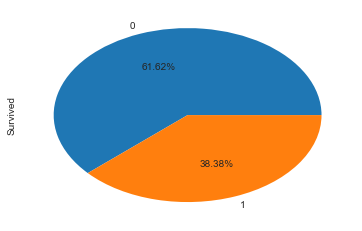

In [5]:
#从上面我们可以看出，Age、Cabin、Embarked、Fare几个特征存在缺失值。
train_data['Survived'].value_counts().plot.pie(autopct='%1.2f%%')#绘制存活的比例

In [ ]:
#缺失值处理方法
#（1）如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；
#（2）如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋
#（3）对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。
train_data.Embarked[train_data.Embarked.isnull()]=train_data.Embarked.dropna().mode().values#缺失俩值，可以用众数赋值。mode是众数
train_data['Cabin'] = train_data.Cabin.fillna('U0')  train_data.Cabin[train_data.Cabin.isnull()]='U0'

#（4）使用回归 随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），
#所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，
#以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征
#（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，但在实际的应用中需要将非数值特征转换为数值特征）'''

In [16]:
from sklearn.ensemble import RandomForestRegressor
#choose training data to predict age
age_df=train_data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_df_notnull=age_df.loc[(train_data['Age'].notnull())]#赋值，age_df_notnull表示age列不是空的数据，6列
age_df_isnull=age_df.loc[(train_data['Age'].isnull())]#loc通过行标签索引行数据，即索引age是空的数据作为age_df_isnull
X=age_df_notnull.values[:,1:] #id之外的数据
Y=age_df_notnull.values[:,0] #passenger id
#use RandomForestRegression to train data
RFR=RandomForestRegressor(n_estimators=1000,n_jobs=-1)#n_estimators是子树的数量，n_jobs是多少处理器是它可以使用，-1意味着没有限制
RFR.fit(X,Y)
predictAges=RFR.predict(age_df_isnull.values[:,1:]) #用随机森林模拟的数据填补6列中的空值（由于cabin的空值是U0，因此没被预测）
train_data.loc[train_data['Age'].isnull(),['Age']]=predictAges #loc索引行列，将预测的age填入null

In [17]:
train_data.info()#查看缺失值处理之后的数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


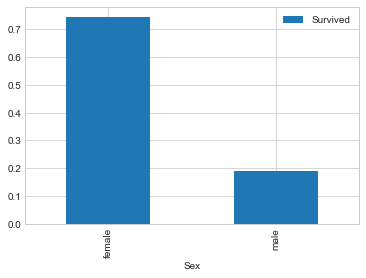

In [19]:
#(1) 性别与是否生存的关系 Sex
train_data.groupby(['Sex','Survived'])['Survived'].count()#分组，男女各存活多少人
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()#结果体现了灾难当时的lady first

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

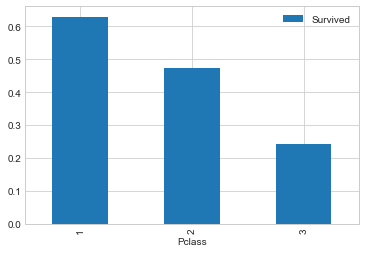

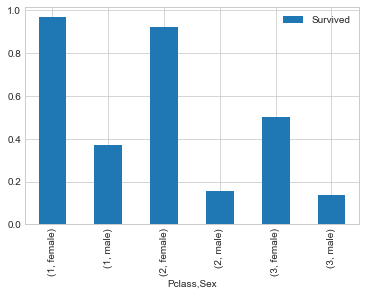

In [23]:
#(2) 船舱等级和生存与否的关系 Pclass
train_data.groupby(['Pclass','Survived'])['Pclass'].count()
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar() #结果中一等舱的人存活率最高
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()#加上性别进行分析
train_data.groupby(['Sex','Pclass','Survived'])['Survived'].count()#总体上妇女优先，但是不同等级船舱还是有一定的区别

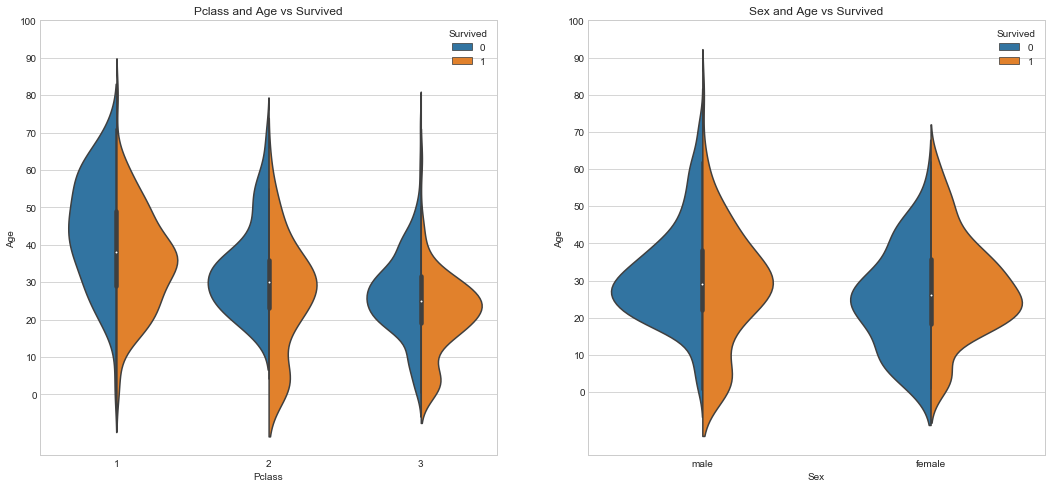

In [27]:
#(3) 年龄与存活与否的关系 Age
fix,ax=plt.subplots(1,2,figsize=(18,8))#将多个图画到一个平面上
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))

sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

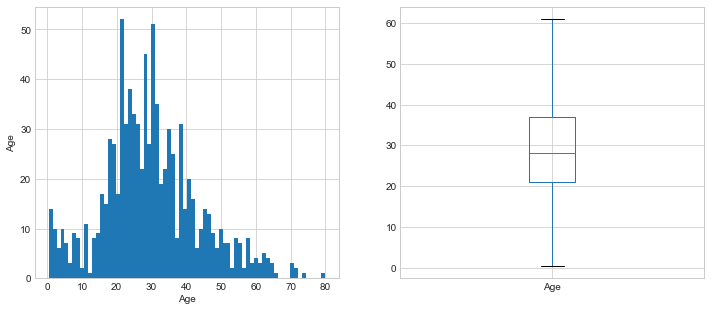

In [29]:
#总体年龄分布
plt.figure(figsize=(12,5))
plt.subplot(121)#显示1行2列个图像，最后的1表示本图像显示在第一个位置
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Age')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=False)
plt.show()

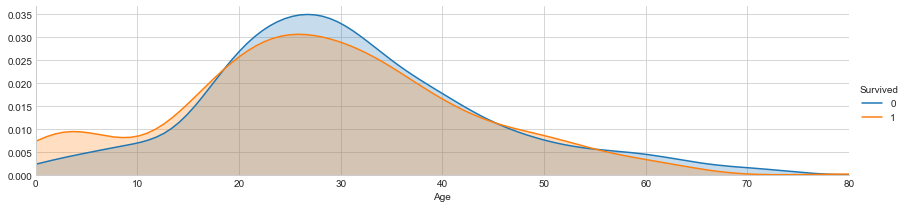

In [30]:
#不同年龄下的生存和非生存的分布情况
facet=sns.FacetGrid(train_data,hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True) #kdeplot是核密度估计图，shade是阴影
facet.set(xlim=(0,train_data['Age'].max()))#合并两个图，x轴范围为0到age最大值
facet.add_legend()#加图例

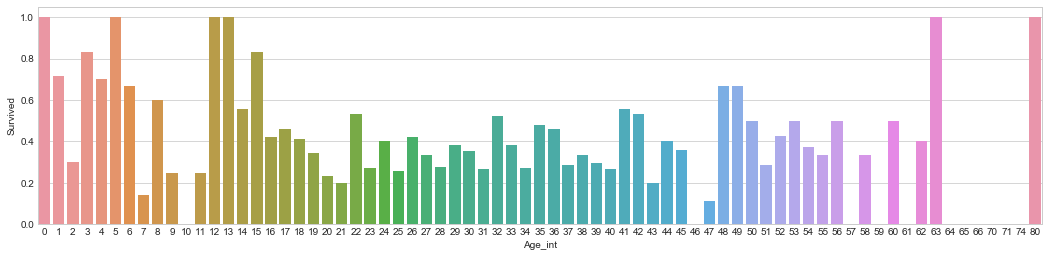

In [32]:
#不同年龄下的生存率
fig,axis1=plt.subplots(1,1,figsize=(18,4))
train_data['Age_int']=train_data['Age'].astype(int)#变量类型转换为int
average_age=train_data[['Age_int','Survived']].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int',y='Survived',data=average_age)

In [33]:
train_data['Age'].describe()

count    891.000000
mean      29.654302
std       13.734963
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [34]:
#样本有891，平均年龄约为30岁，标准差13.5岁，最小年龄为0.42，最大年龄80.
#按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还情况
bins=[0,12,18,65,100]
train_data['Age_group']=pd.cut(train_data['Age'],bins)
by_age=train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

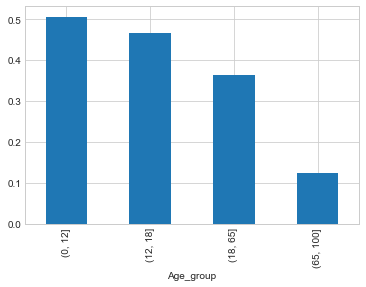

In [35]:
by_age.plot(kind='bar')

In [36]:
#(4) 称呼与存活与否的关系 Name
#通过观察名字数据，我们可以看出其中包括对乘客的称呼，如：Mr、Miss、Mrs等，称呼信息包含了乘客的年龄、性别，同时也包含了如社会地位等的称呼，如：Dr,、Lady、Major、Master等的称呼。
train_data['Title']=train_data['Name'].str.extract('([A-Za-z]+)\.',expand=False)#提取字母，获得乘客的称呼
pd.crosstab(train_data['Title'],train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


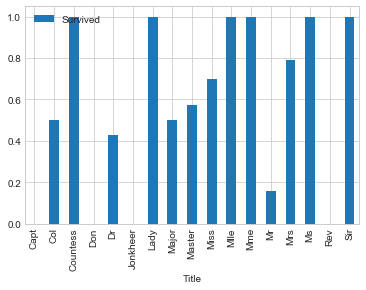

In [37]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()#观察不同称呼与生存率的关系

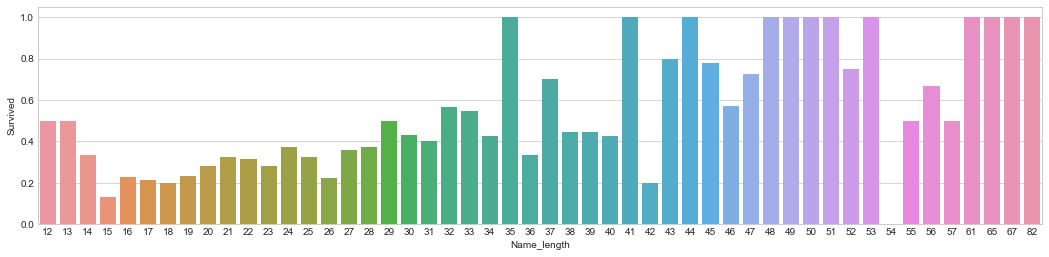

In [38]:
#名字长度和生存率之间存在关系的可能,结果中名字长度和生存与否确实也存在一定的相关性
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

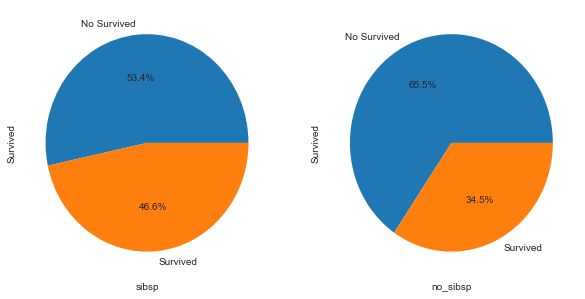

In [39]:
#(5) 有无兄弟姐妹和存活与否的关系 SibSp
# 将数据分为有兄弟姐妹的和没有兄弟姐妹的两组：
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()

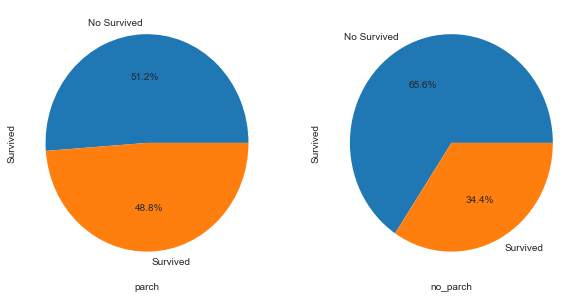

In [40]:
#(6) 有无父母子女和存活与否的关系 Parch
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_parch')

plt.show()

Text(0.5,1,'SibSp and Survived')

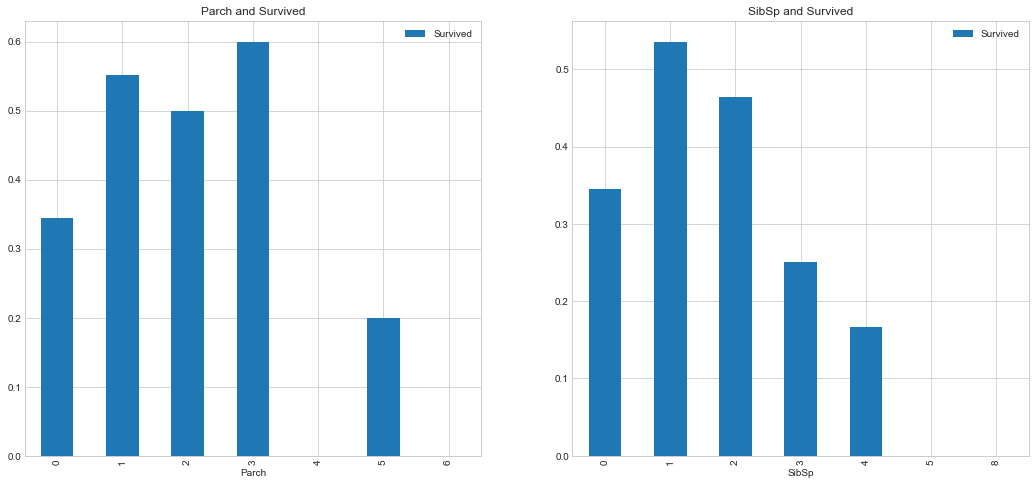

In [41]:
#(7) 亲友的人数和存活与否的关系 SibSp & Parch
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

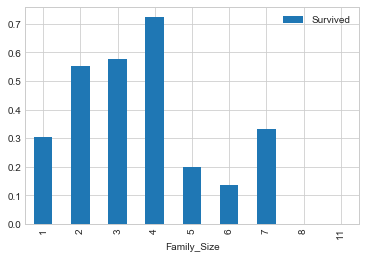

In [42]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()
#若独自一人，那么其存活率比较低；但是如果亲友太多的话，存活率也会很低。

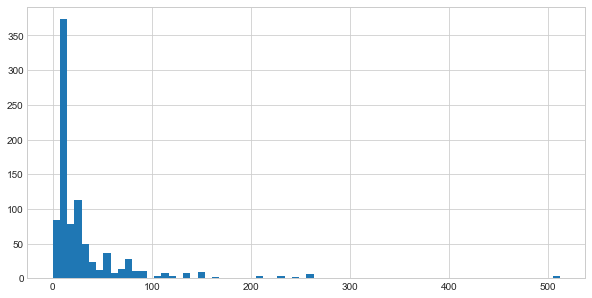

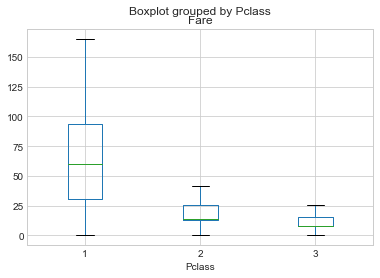

In [43]:
#(8) 票价分布和存活与否的关系 Fare
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins = 70)

train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

In [44]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

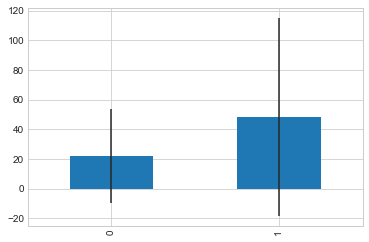

In [45]:
#绘制生存与否与票价均值和方差的关系
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show()#票价与是否生还有一定的相关性，生还者的平均票价要大于未生还者的平均票价

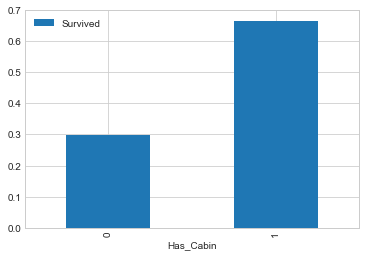

In [46]:
#(9) 船舱类型和存活与否的关系 Cabin
#由于船舱的缺失值确实太多，有效值仅仅有204个，很难分析出不同的船舱和存活的关系，所以在做特征工程的时候，可以直接将该组特征丢弃。
#当然，这里我们也可以对其进行一下分析，对于缺失的数据都分为一类。
#简单地将数据分为是否有Cabin记录作为特征，与生存与否进行分析：
train_data.loc[train_data.Cabin.isnull(), 'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

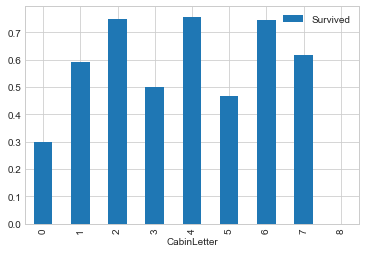

In [47]:
#对不同类型的船舱进行分析
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
#re.compile()函数，将正则表达式的字符串形式编译为Pattern实例，然后使用Pattern实例处理文本并获得匹配结果（一个Match实例），最后使用Match实例获得信息，进行其他的操作。

# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()

Text(0.5,1,'Embarked and Survived')

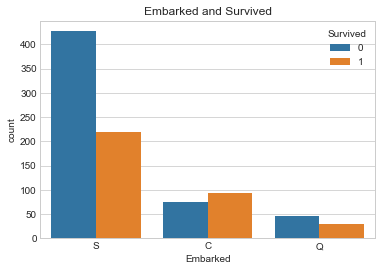

In [48]:
#(10) 港口和存活与否的关系 Embarked
#泰坦尼克号从英国的南安普顿港出发，途径法国瑟堡和爱尔兰昆士敦，那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

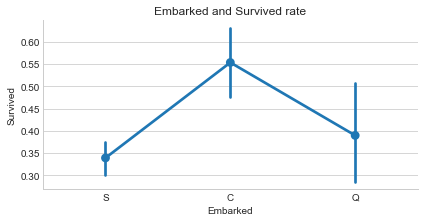

In [49]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()#可以看出，在不同的港口上船，生还率不同，C最高，Q次之，S最低。

'''据了解，泰坦尼克号上共有2224名乘客。本训练数据只给出了891名乘客的信息，
如果该数据集是从总共的2224人中随机选出的，根据中心极限定理，该样本的数据也足够大，
那么我们的分析结果就具有代表性；但如果不是随机选取，那么我们的分析结果就可能不太靠谱了。

(11) 其他可能和存活与否有关系的特征
对于数据集中没有给出的特征信息，我们还可以联想其他可能会对模型产生影响的特征因素。如：乘客的国籍、乘客的身高、乘客的体重、乘客是否会游泳、乘客职业等等。
另外还有数据集中没有分析的几个特征：Ticket（船票号）、Cabin（船舱号）,这些因素的不同可能会影响乘客在船中的位置从而影响逃生的顺序。
但是船舱号数据缺失，船票号类别大，难以分析规律，所以在后期模型融合的时候，将这些因素交由模型来决定其重要性。'''

'''Scikit-learn要求数据都是数字型numeric，所以我们要将一些非数字型的原始数据转换为数字型numeric
数据分成两类：1.定性(Quantitative)变量可以以某种方式排序，Age就是一个很好的列子。
2.定量(Qualitative)变量描述了物体的某一（不能被数学表示的）方面，Embarked就是一个例子。

定性(Qualitative)转换：

1. Dummy Variables
就是类别变量或者二元变量，当qualitative variable是一些频繁出现的几个独立变量时，
Dummy Variables比较适合使用。我们以Embarked为例，Embarked只包含三个值’S’,’C’,’Q’，
我们可以使用下面的代码将其转换为dummies:
'''

In [52]:
embark_dummies  = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'], axis=1,inplace=True)
embark_dummies = train_data[['S', 'C', 'Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [53]:
'''2. Factorizing
dummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。
所以Pandas有一个方法叫做factorize()，它可以创建一些数字，来表示类别变量，
对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。'''

'2. Factorizing\ndummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。\n所以Pandas有一个方法叫做factorize()，它可以创建一些数字，来表示类别变量，\n对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。'

In [54]:
# Replace missing values with "U0"
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

'''定量(Quantitative)转换：

1. Scaling

Scaling可以将一个很大范围的数值映射到一个很小的范围(通常是-1 - 1，
或则是0 - 1)，很多情况下我们需要将数值做Scaling使其范围大小一样，
否则大范围数值特征将会由更高的权重。比如：Age的范围可能只是0-100，
而income的范围可能是0-10000000，在某些对数组大小敏感的模型中会影响其结果。
下面对Age进行Scaling
'''

In [56]:
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891#assert断言是声明其布尔值必须为真的判定，如果发生异常就说明表达示为假
# StandardScaler will subtract the mean from each value then scale to the unit variance
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))#将数据变成-1到1之间
train_data['Age_scaled'].head()

0   -0.557599
1    0.607966
2   -0.266208
3    0.389422
4    0.389422
Name: Age_scaled, dtype: float64

In [60]:
#2. Binning
#Binning通过观察“邻居”(即周围的值)将连续数据离散化。存储的值被分布到一些“桶”或“箱“”中，就像直方图的bin将数据划分成几块一样。下面的代码对Fare进行Binning。
train_data['Fare_bin']=pd.qcut(train_data['Fare'],5)#按分位数分成5份
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

In [61]:
#在将数据Bining化后，要么将数据factorize化，要么dummies化
train_data['Fare_bin_id']=pd.factorize(train_data['Fare_bin'])[0]
fare_bin_dummies_df=pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x:'Fare_'+str(x))
train_data=pd.concat([train_data,fare_bin_dummies_df],axis=1) #concat表融合

In [63]:
#5. 特征工程
#在进行特征工程的时候，我们不仅需要对训练数据进行处理，还需要同时将测试数据同训练数据一起处理，使得二者具有相同的数据类型和数据分布。
trainpath2=open('E:\\finance and data science\\kaggle和天池比赛\\泰坦尼克\\train.csv')
testpath2=open('E:\\finance and data science\\kaggle和天池比赛\\泰坦尼克\\test.csv')
train_df_org = pd.read_csv(trainpath2)
test_df_org = pd.read_csv(testpath2)
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']
#对数据进行特征工程，也就是从各项参数中提取出对输出结果有或大或小的影响的特征，将这些特征作为训练模型的依据。
#一般来说，我们会先从含有缺失值的特征开始。

In [64]:
#(1) Embarked
#因为“Embarked”项的缺失值不多，所以这里我们以众数来填充：
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace=True)#iloc相比loc只提取行的int
#因为只有三个港口，所以我们可以直接用dummy来处理：
#为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]
# 使用 pd.get_dummies 获取one-hot 编码（即 One-Hot编码，又称为一位有效编码，主要是采用位状态寄存器来对个状态进行编码，每个状态都由他独立的寄存器位，并且在任意时候只有一位有效。））
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'], prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)

In [65]:
#(2) Sex
#对Sex也进行one-hot编码，也就是dummy处理：
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]
sex_dummies_df = pd.get_dummies(combined_train_test['Sex'], prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

In [67]:
#(3) Name
#首先先从名字中提取各种称呼
combined_train_test['Title']=combined_train_test['Name'].map(lambda x:re.compile(",(.*?)\.").findall(x)[0])
#将各式称呼进行统一化处理，一键对应多值
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

In [68]:
#使用dummy对不同的称呼进行分列
# 为了后面的特征分析，这里我们也将 Title 特征进行facrorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]
title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)
#增加名字长度的特征
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

In [69]:
#(4) Fare
#由前面分析可以知道，Fare项在测试数据中缺少一个值，用均值进行填充。 
#我们按照一二三等舱各自的均价来填充：下面transform将函数np.mean应用到各个group中。
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))
#通过对Ticket数据的分析，我们可以看到部分票号数据有重复，同时结合亲属人数及名字的数据，和票价船舱等级对比，我们可以知道购买的票中有家庭票和团体票，所以我们需要将团体票的票价分配到每个人的头上。
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)
#使用binning给票价分等级
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'], 5)
#对于5个等级的票价我们也可以继续使用dummy为票价等级分列
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]
fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test = pd.concat([combined_train_test, fare_bin_dummies_df], axis=1)
combined_train_test.drop(['Fare_bin'], axis=1, inplace=True)

In [71]:
#(5) Pclass
#Pclass这一项，其实已经可以不用继续处理了，我们只需要将其转换为dummy形式即可。
#但是为了更好的分析问题，我们这里假设对于不同等级的船舱，各船舱内部的票价也说明了各等级舱的位置，那么也就很有可能与逃生的顺序有关系。所以这里分出每等舱里的高价和低价位。
from sklearn.preprocessing import LabelEncoder

# 建立PClass Fare Category对3个等级的船舱进行二分
def pclass_fare_category(df, pclass1_mean_fare, pclass2_mean_fare, pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'

Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

# 建立Pclass_Fare Category
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category, args=(
    Pclass1_mean_fare, Pclass2_mean_fare, Pclass3_mean_fare), axis=1)
pclass_level = LabelEncoder()

# 给每一项添加标签
pclass_level.fit(np.array(
    ['Pclass1_Low', 'Pclass1_High', 'Pclass2_Low', 'Pclass2_High', 'Pclass3_Low', 'Pclass3_High']))

# 转换成数值
combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

# dummy 转换
pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x: 'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test, pclass_dummies_df], axis=1)
#同时，我们将 Pclass 特征factorize化：
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]

In [72]:
#(6) Parch and SibSp
#由前面的分析，我们可以知道，亲友的数量没有或者太多会影响到Survived。所以将二者合并为FamliySize这一组合项，同时也保留这两项。
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()#标准化标签，将标签值统一转换成range(标签值个数-1)范围内
le_family.fit(np.array(['Single', 'Small_Family', 'Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])

family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'],
                                        prefix=combined_train_test[['Family_Size_Category']].columns[0])
combined_train_test = pd.concat([combined_train_test, family_size_dummies_df], axis=1)

(7) Age
因为Age项的缺失值较多，所以不能直接填充age的众数或者平均数。
常见的有两种对年龄的填充方式：一种是根据Title中的称呼，如Mr，Master、Miss等称呼不同类别的人的平均年龄来填充；一种是综合几项如Sex、Title、Pclass等其他没有缺失值的项，使用机器学习算法来预测Age。
这里我们使用后者来处理。以Age为目标值，将Age完整的项作为训练集，将Age缺失的项作为测试集。

In [75]:
missing_age_df = pd.DataFrame(combined_train_test[
    ['Age', 'Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass']])
missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]
missing_age_test.head()

,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
5,NaN,2,0,-1,16,1,1,8.4583,2,0
17,NaN,0,0,-1,28,1,1,13.0000,3,2
19,NaN,1,1,-1,23,1,1,7.2250,4,0
26,NaN,1,0,-1,23,1,1,7.2250,4,0
28,NaN,2,1,-1,29,1,1,7.8792,0,0


In [78]:
#建立Age的预测模型，我们可以多模型预测，然后再做模型的融合，提高预测的精度。
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train, missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
    missing_age_Y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

    # model 1  gbm
    gbm_reg = GradientBoostingRegressor(random_state=42)
    gbm_reg_param_grid = {'n_estimators': [2000], 'max_depth': [4], 'learning_rate': [0.01], 'max_features': [3]}
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg, gbm_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:' + str(gbm_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])

    # model 2 rf
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid = {'n_estimators': [200], 'max_depth': [5], 'random_state': [0]}
    rf_reg_grid = model_selection.GridSearchCV(rf_reg, rf_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    rf_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor' + str(rf_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_RF'] = rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])

    # two models merge
    print('shape1', missing_age_test['Age'].shape, missing_age_test[['Age_GB', 'Age_RF']].mode(axis=1).shape)
    # missing_age_test['Age'] = missing_age_test[['Age_GB', 'Age_LR']].mode(axis=1)

    missing_age_test.loc[:, 'Age'] = np.mean([missing_age_test['Age_GB'], missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])

    missing_age_test.drop(['Age_GB', 'Age_RF'], axis=1, inplace=True)

    return missing_age_test

In [80]:
#利用融合模型预测的结果填充Age的缺失值：
combined_train_test.loc[(combined_train_test.Age.isnull()), 'Age'] = fill_missing_age(missing_age_train, missing_age_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    8.0s finished


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-157.359955964
GB Train Error for "Age" Feature Regressor:-76.2823828466
5     36.512959
17    33.012546
19    22.456516
26    28.614044
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    7.2s finished


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-146.198499257
RF Train Error for "Age" Feature Regressor-116.502683198
5     31.001134
17    33.725938
19    25.427105
26    27.893547
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     29.778382
17    29.778382
19    29.778382
26    29.778382
Name: Age, dtype: float64


(8) Ticket
观察Ticket的值，我们可以看到，Ticket有字母和数字之分，而对于不同的字母，
可能在很大程度上就意味着船舱等级或者不同船舱的位置，也会对Survived产生一定的影响，
所以我们将Ticket中的字母分开，为数字的部分则分为一类。

In [82]:
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket_Letter'].apply(lambda x: 'U0' if x.isnumeric() else x)

# 如果要提取数字信息，则也可以这样做，现在我们对数字票单纯地分为一类。
# combined_train_test['Ticket_Number'] = combined_train_test['Ticket'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# combined_train_test['Ticket_Number'].fillna(0, inplace=True)

# 将 Ticket_Letter factorize
combined_train_test['Ticket_Letter'] = pd.factorize(combined_train_test['Ticket_Letter'])[0]

(9) Cabin

因为Cabin项的缺失值确实太多了，我们很难对其进行分析，或者预测。
所以这里我们可以直接将Cabin这一项特征去除。但通过上面的分析，可以知道，
该特征信息的有无也与生存率有一定的关系，所以这里我们暂时保留该特征，并将其分为有和无两类。

In [83]:
combined_train_test.loc[combined_train_test.Cabin.isnull(), 'Cabin'] = 'U0'
combined_train_test['Cabin'] = combined_train_test['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)

特征间相关性分析

我们挑选一些主要的特征，生成特征之间的关联图，查看特征与特征之间的相关性：

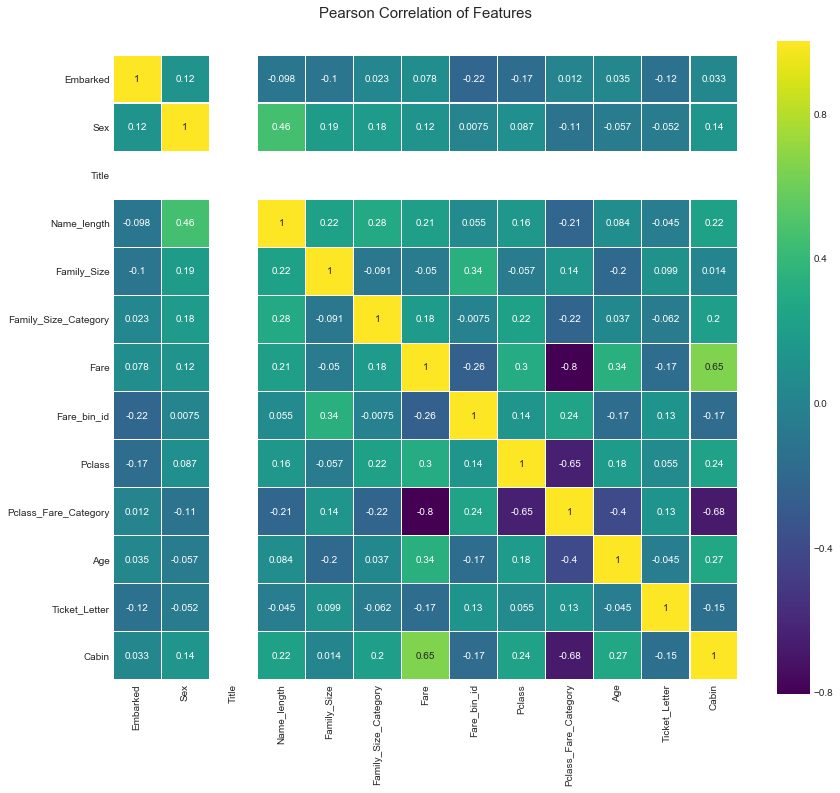

In [84]:
Correlation = pd.DataFrame(combined_train_test[
    ['Embarked', 'Sex', 'Title', 'Name_length', 'Family_Size', 'Family_Size_Category','Fare', 'Fare_bin_id', 'Pclass', 
     'Pclass_Fare_Category', 'Age', 'Ticket_Letter', 'Cabin']])

colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

特征之间的数据分布图

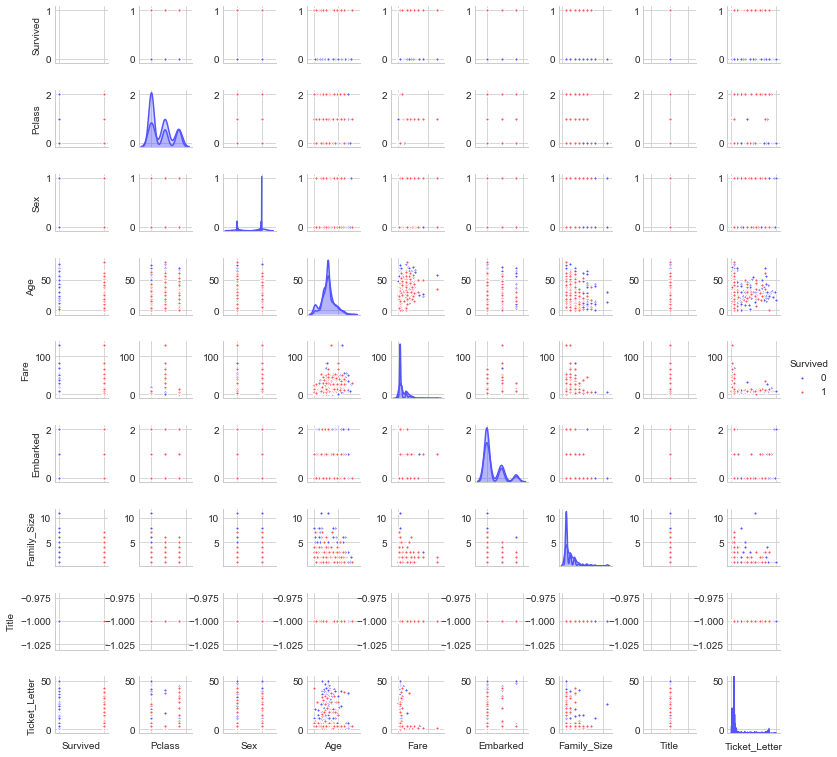

In [85]:
g = sns.pairplot(combined_train_test[[u'Survived', u'Pclass', u'Sex', u'Age', u'Fare', u'Embarked',
       u'Family_Size', u'Title', u'Ticket_Letter']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

输入模型前的一些处理：

1. 一些数据的正则化
这里我们将Age和fare进行正则化：

In [86]:
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare', 'Name_length']])
combined_train_test[['Age','Fare', 'Name_length']] = scale_age_fare.transform(combined_train_test[['Age','Fare', 'Name_length']])

2. 弃掉无用特征

对于上面的特征工程中，我们从一些原始的特征中提取出了很多要融合到模型中的特征，但是我们需要剔除那些原本的我们用不到的或者非数值特征：

首先对我们的数据先进行一下备份，以便后期的再次分析：

In [90]:
combined_data_backup = combined_train_test

combined_train_test.drop(['PassengerId', 'Embarked', 'Sex', 'Name', 'Title', 'Fare_bin_id', 'Pclass_Fare_Category', 
                          'Parch', 'SibSp', 'Family_Size_Category', 'Ticket'],axis=1,inplace=True)

3. 将训练数据和测试数据分开：

In [91]:
train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)
titanic_train_data_X.shape

(891, 33)

### 6. 模型融合及测试

模型融合的过程需要分几步来进行。

#### (1) 利用不同的模型来对特征进行筛选，选出较为重要的特征：

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))

    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))

    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))

    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt], 
                               ignore_index=True).drop_duplicates()

    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et, 
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)

    return features_top_n , features_importance

### (2) 依据我们筛选出的特征构建训练集和测试集

但如果在进行特征工程的过程中，产生了大量的特征，而特征与特征之间会存在一定的相关性。太多的特征一方面会影响模型训练的速度，另一方面也可能会使得模型过拟合。所以在特征太多的情况下，我们可以利用不同的模型对特征进行筛选，选取出我们想要的前n个特征。

In [93]:
feature_to_pick = 30
feature_top_n, feature_importance = get_top_n_features(titanic_train_data_X, titanic_train_data_Y, feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    9.5s remaining:    5.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   14.3s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.82379349046
Top N Features RF Train Score:0.978675645342
Sample 10 Features from RF Classifier
10               Name_length
0                        Age
7                      Sex_0
8                      Sex_1
2                       Fare
28               Family_Size
32             Ticket_Letter
3                     Pclass
1                      Cabin
31    Family_Size_Category_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    9.6s remaining:    5.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   14.4s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.809203142536
Top N Features Ada Train Score:0.838383838384
Sample 10 Feature from Ada Classifier:
0                        Age
10               Name_length
2                       Fare
32             Ticket_Letter
7                      Sex_0
28               Family_Size
8                      Sex_1
3                     Pclass
4                 Embarked_0
29    Family_Size_Category_0
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    9.6s remaining:    5.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   14.4s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET Score:0.828282828283
Top N Features ET Train Score:0.973063973064
Sample 10 Features from ET Classifier:
7                      Sex_0
8                      Sex_1
0                        Age
10               Name_length
2                       Fare
1                      Cabin
32             Ticket_Letter
31    Family_Size_Category_2
28               Family_Size
3                     Pclass
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   15.2s remaining:    8.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   20.3s finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.778900112233
Top N Features GB Train Score:0.996632996633
Sample 10 Feature from GB Classifier:
0               Age
2              Fare
10      Name_length
32    Ticket_Letter
7             Sex_0
8             Sex_1
3            Pclass
28      Family_Size
18         Pclass_2
1             Cabin
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    8.7s remaining:    4.6s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   13.3s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT Score:0.754208754209
Top N Features DT Train Score:0.96632996633
Sample 10 Features from DT Classifier:
7                      Sex_0
0                        Age
2                       Fare
10               Name_length
3                     Pclass
1                      Cabin
31    Family_Size_Category_2
29    Family_Size_Category_0
32             Ticket_Letter
20                  Pclass_4
Name: feature, dtype: object


用视图可视化不同算法筛选的特征排序：

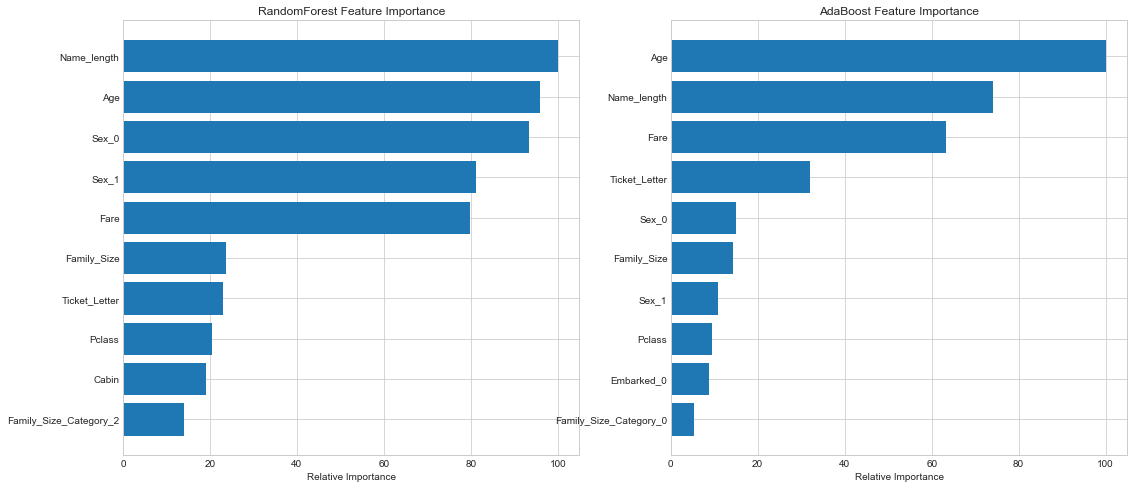

In [104]:
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[33:33+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = 100.0 * (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize = (18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos, rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

### (3) 模型融合（Model Ensemble）

常见的模型融合方法有：Bagging、Boosting、Stacking、Blending。

(3-1):Bagging

Bagging 将多个模型，也就是多个基学习器的预测结果进行简单的加权平均或者投票。它的好处是可以并行地训练基学习器。Random Forest就用到了Bagging的思想。

(3-2): Boosting

Boosting 的思想有点像知错能改，每个基学习器是在上一个基学习器学习的基础上，对上一个基学习器的错误进行弥补。我们将会用到的 AdaBoost，Gradient Boost 就用到了这种思想。

(3-3): Stacking

Stacking是用新的次学习器去学习如何组合上一层的基学习器。如果把 Bagging 看作是多个基分类器的线性组合，那么Stacking就是多个基分类器的非线性组合。Stacking可以将学习器一层一层地堆砌起来，形成一个网状的结构。

相比来说Stacking的融合框架相对前面的二者来说在精度上确实有一定的提升，所以在下面的模型融合上，我们也使用Stacking方法。

(3-4): Blending

Blending 和 Stacking 很相似，但同时它可以防止信息泄露的问题。

### Stacking框架融合:

这里我们使用了两层的模型融合，Level 1使用了：RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM ，一共7个模型，Level 2使用了XGBoost使用第一层预测的结果作为特征对最终的结果进行预测。

Level 1：

Stacking框架是堆叠使用基础分类器的预测作为对二级模型的训练的输入。 然而，我们不能简单地在全部训练数据上训练基本模型，产生预测，输出用于第二层的训练。如果我们在Train Data上训练，然后在Train Data上预测，就会造成标签。为了避免标签，我们需要对每个基学习器使用K-fold，将K个模型对Valid Set的预测结果拼起来，作为下一层学习器的输入。

所以这里我们建立输出fold预测方法：

In [107]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain = titanic_train_data_X.shape[0]
ntest = titanic_test_data_X.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 7 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

构建不同的基学习器，这里我们使用了RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM 七个基学习器：（这里的模型可以使用如上面的GridSearch方法对模型的超参数进行搜索选择）

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500, warm_start=True, max_features='sqrt',max_depth=6, 
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors = 2)

svm = SVC(kernel='linear', C=0.025)

将pandas转换为arrays：

In [109]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
x_train = titanic_train_data_X.values # Creates an array of the train data
x_test = titanic_test_data_X.values # Creats an array of the test data
y_train = titanic_train_data_Y.values

In [110]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_out_fold(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_out_fold(ada, x_train, y_train, x_test) # AdaBoost 
et_oof_train, et_oof_test = get_out_fold(et, x_train, y_train, x_test) # Extra Trees
gb_oof_train, gb_oof_test = get_out_fold(gb, x_train, y_train, x_test) # Gradient Boost
dt_oof_train, dt_oof_test = get_out_fold(dt, x_train, y_train, x_test) # Decision Tree
knn_oof_train, knn_oof_test = get_out_fold(knn, x_train, y_train, x_test) # KNeighbors
svm_oof_train, svm_oof_test = get_out_fold(svm, x_train, y_train, x_test) # Support Vector

print("Training is complete")

Training is complete


### (4) 预测并生成提交文件

Level 2：

我们利用XGBoost，使用第一层预测的结果作为特征对最终的结果进行预测。

In [112]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train, gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test, gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)

In [115]:
from xgboost import XGBClassifier

gbm = XGBClassifier( n_estimators= 2000, max_depth= 4, min_child_weight= 2, gamma=0.9, subsample=0.8, 
                        colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [116]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False,sep=',')

### 7. 验证：学习曲线

在我们对数据不断地进行特征工程，产生的特征越来越多，用大量的特征对模型进行训练，会使我们的训练集拟合得越来越好，但同时也可能会逐渐丧失泛化能力，从而在测试数据上表现不佳，发生过拟合现象。

当然我们建立的模型可能不仅在预测集上表型不好，也很可能是因为在训练集上的表现就不佳，处于欠拟合状态。

以下是在吴恩达老师的机器学习课程上给出的四种学习曲线(low high variance bias)

最优情况，随着样本的增加，train error虽然有一定的增加吗，但是 test error却有很明显的降低；
最差情况，train error很大，模型并没有从特征中学习到什么，导致test error非常大，模型几乎无法预测数据，需要去寻找数据本身和训练阶段的原因；
high variance的情况，train error虽然较低，但是模型产生了过拟合，缺乏泛化能力，导致test error很高；
右下角是high bias的情况，train error很高，这时需要去调整模型的参数，减小train error。

所以我们通过学习曲线观察模型处于什么样的状态。从而决定对模型进行如何的操作。当然，我们把验证放到最后，并不是是这一步是在最后去做。对于我们的Stacking框架中第一层的各个基学习器我们都应该对其学习曲线进行观察，从而去更好地调节超参数，进而得到更好的最终结果。

构建绘制学习曲线的函数：

In [119]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [120]:
X = x_train
Y = y_train

# RandomForest
rf_parameters = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 'max_depth': 6, 'min_samples_leaf': 2, 
                 'max_features' : 'sqrt','verbose': 0}

# AdaBoost
ada_parameters = {'n_estimators':500, 'learning_rate':0.1}

# ExtraTrees
et_parameters = {'n_jobs': -1, 'n_estimators':500, 'max_depth': 8, 'min_samples_leaf': 2, 'verbose': 0}

# GradientBoosting
gb_parameters = {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 2, 'verbose': 0}

# DecisionTree
dt_parameters = {'max_depth':8}

# KNeighbors
knn_parameters = {'n_neighbors':2}

# SVM
svm_parameters = {'kernel':'linear', 'C':0.025}

# XGB
gbm_parameters = {'n_estimators': 2000, 'max_depth': 4, 'min_child_weight': 2, 'gamma':0.9, 'subsample':0.8, 
                  'colsample_bytree':0.8, 'objective': 'binary:logistic', 'nthread':-1, 'scale_pos_weight':1}

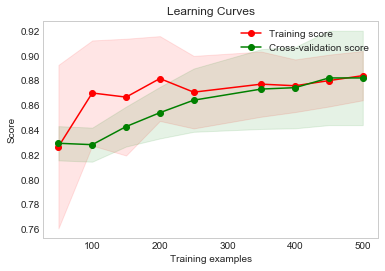

In [121]:
title = "Learning Curves"
plot_learning_curve(RandomForestClassifier(**rf_parameters), title, X, Y, cv=None,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

由上面的分析我们可以看出，对于RandomForest的模型，这里是存在一定的问题的，所以我们需要去调整模型的超参数，从而达到更好的效果。

### 8. 超参数调试

将生成的提交文件到Kaggle提交，得分结果：

xgboost stacking：0.78468；
voting bagging ：0.79904；
这也说明了我们的stacking模型还有很大的改进空间。所以我们可以在以下几个方面进行改进，提高模型预测的精度：

特征工程：寻找更好的特征、删去影响较大的冗余特征；
模型超参数调试：改进欠拟合或者过拟合的状态；
改进模型框架：对于stacking框架的各层模型进行更好的选择；